Imports and load charged hadrons from file:

In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Zbb_ecm91_EvtGen_Bs2PhiGamma"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_000640066.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_container = "ReconstructedParticles"
h_c = f'{h_container}/{h_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_c in v):
        keep_vars.append(v)

n_keep = 50000
h = tree.arrays(keep_vars,how="zip")[:n_keep]

Build $\phi$ candidates:

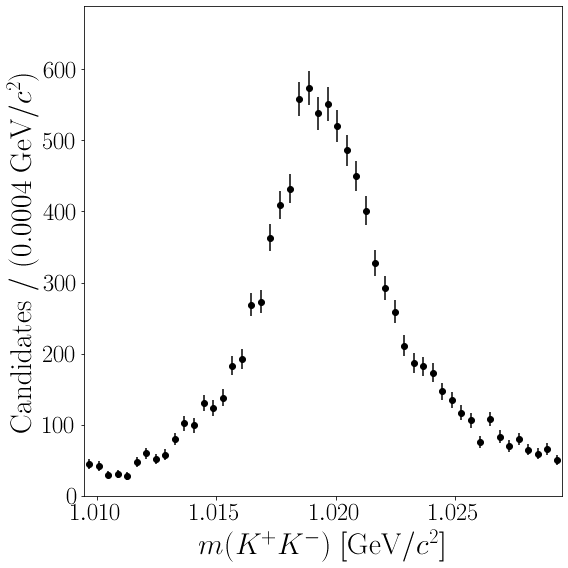

In [2]:
h[h_c,'p'] = kinematics.calc_p(h,h_c)
p_cut = h[h_c,"p"] > 1.5
h = h[p_cut]

k_cut = abs(h[h_c,"mass"] - lp.K_plus.mass/1000.) < 1e-4
h["k"] = h[h_c][k_cut]

phi = ak.combinations(h["k"],2)
phi_k1, phi_k2 = ak.unzip(phi)
phi_cut = np.sign(phi_k1["charge"]) != np.sign(phi_k2["charge"])
phi = phi[phi_cut]
phi["k1"], phi["k2"] = ak.unzip(phi)

PDG_K_m = lp.K_plus.mass/1000.
phi["mass"] = kinematics.mass([phi["k1"], phi["k2"]], [PDG_K_m, PDG_K_m])

PDG_phi_m = lp.phi_1020.mass/1000.
phi_window = 0.01
phi_cut = abs(phi["mass"] - PDG_phi_m) < phi_window
phi = phi[phi_cut]

plotting.errorbar_hist(phi,"mass",f"{file_type}_Phi_M","$m(K^+ K^-)$","GeV/$c^2$",PDG_phi_m-phi_window,PDG_phi_m+phi_window,50)

Build $B_s^0 \to \phi \gamma$ candidates:

In [3]:
gamma_cut = abs(h[h_c,"mass"] - lp.gamma.mass/1000.) < 1e-4
gamma = h[h_c][gamma_cut]
PDG_gamma_m = lp.gamma.mass/1000.

B = ak.cartesian({"phi_k1": phi["k1"], "phi_k2": phi["k2"], "gamma": gamma})
B["mass"] = kinematics.mass([B["phi_k1"], B["phi_k2"], B["gamma"]], [PDG_K_m, PDG_K_m, PDG_gamma_m])

Keep $B^\pm$ candidates within a certain mass range and plot:

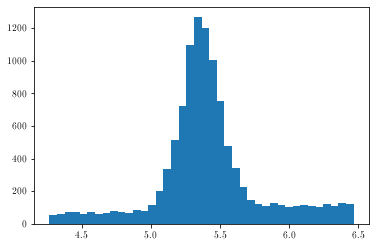

In [4]:
PDG_Bs_m = lp.B_s_0.mass/1000.
window = 1.1
low = PDG_Bs_m - window
high = PDG_Bs_m + window
B_cut = np.logical_and(B["mass"] > low, B["mass"] < high)
B = B[B_cut]

plt.hist(ak.flatten(B["mass"]),bins=40)
plt.show()

Fit the distribution with zfit, including a signal peak component and an exponential component for random combinations:

In [5]:
obs = zfit.Space('mB', limits=(low, high))

rand = random.randint(0,999)
#Signal PDF
B_mu = zfit.Parameter(f"B_mu_{rand}", PDG_Bs_m, low, high)
B_sigma = zfit.Parameter(f"B_sigma_{rand}", 0.05, 0., 0.5)
B_alphaL = zfit.Parameter(f"B_alphaL_{rand}", 0.5, 0., 5.)
B_nL = zfit.Parameter(f"B_nL_{rand}", 100., 0., 200.)
B_alphaR = zfit.Parameter(f"B_alphaR_{rand}", -0.5, -5., 0.)
B_nR = zfit.Parameter(f"B_nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

n_sig = zfit.Parameter(f"n_sig_{rand}", 7000., 0., 50000.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaL, n=B_nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaR, n=B_nR)
pdf_sig = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac).create_extended(n_sig)

#Background PDF
comb = zfit.Parameter(f"comb_{rand}", 0., -1, 1.)

n_bkg = zfit.Parameter(f"n_bkg_{rand}", 2000., 0., 10000.)

pdf_bkg = zfit.pdf.Chebyshev(obs=obs, coeffs=[comb]).create_extended(n_bkg)

#Total PDF
pdf = zfit.pdf.SumPDF([pdf_sig, pdf_bkg])

In [6]:
data_np = ak.to_numpy(ak.flatten(B["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [8]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
#param_errors, _ = result.errors(method="minuit_minos")
param_errors = result.hesse()

print("m(Bs) fit function minimum:", result.fmin)
print("m(Bs) fit converged:", result.converged)
print("m(Bs) fit full minimizer information:", result.info)

params = result.params
print(params)

n_sig_val = params[n_sig]['value']

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8.734e+04                 │       Ncalls = 689 (689 total)       │
│ EDM = 5.03e-05 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(Bs) fit function minimum: -87340.32677709009
m(Bs) fit converged: True
m(Bs) fit full minimizer information: {'n_eval': 689, 'n_iter': 689, 'original': FMin(fval=-87340.32677709009, edm=5.0344073660900036e-05, tolerance=0.01, nfcn=689, nc

Plot the fit result:

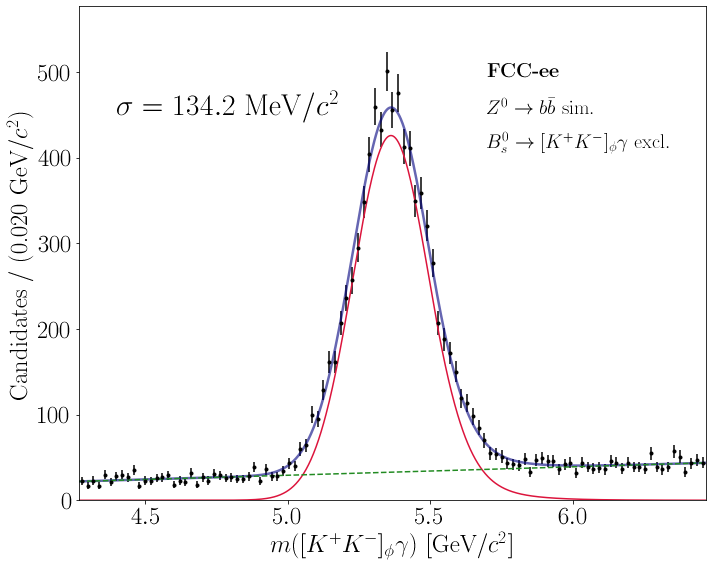

In [10]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.02
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_sig*params[n_sig]['value']/bins*obs.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_bkg*params[n_bkg]['value']/bins*obs.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m([K^+ K^-]_\phi \gamma)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(5.7,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(5.7,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(5.7,0.74*ymax,"$B_s^0 \\to [K^+ K^-]_\\phi \\gamma$ excl.",fontsize=20)
sigma_val = 1000.*params[B_sigma]['value']
plt.text(4.4,0.82*ymax,"$\\sigma = %.1f$ MeV/$c^2$" % sigma_val,fontsize=30)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Bs_M_fit.pdf")

Estimate the expected yield of this mode per year and per experiment:

In [11]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of b quarks produced
N_b = 2 * 0.1512 * N_Z
#Number of Bs -> phi gamma produced
N_Bs2PhiGamma = N_b * 0.096 * 3.4e-5 * 0.492

print("N expected per year per exp = %.3e" % N_Bs2PhiGamma)

N expected per year per exp = 1.821e+05
